<a href="https://www.kaggle.com/code/yashwinibansal/yolov1-implementation-with-batchnorm?scriptVersionId=125422029" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

import os
import sys

import pandas as pd
from PIL import Image

import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
""" 
YOLOv1 architechture

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf
page3

tuples description:
    (kernel_size, filters, stride, padding) 
maxpooling with stride 2x2 and kernel 2x2
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",                  # maxpooling
    (3, 192, 1, 1),
    "M",                  # maxpooling
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",                  # maxpooling
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],       # tuples and number of repeats=4
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",                  # maxpooling
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],       # tuples and number of repeats=2
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [4]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [ CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3]) ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [ nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) ]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [ CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]) ]
                    layers += [ CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]) ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [5]:
# def test(S=7, B=2, C=20):
#     model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
#     x = torch.randn((2, 3, 448, 448))
#     print(model(x).shape)
    
# test()

In [6]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [7]:
"""
Implementation of Yolo Loss Function from the original yolo paper

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf
page4
"""

class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S - split size of image
        B - number of boxes
        C - number of classes
        """
        self.S = S
        self.B = B
        self.C = C

        # for calculating loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # input predictions are shaped (BATCH_SIZE, S * S * (C + B * 5)
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out the prediction with highest Iou
        box_predictions = exists_box * (
            bestbox * predictions[..., 26:30]
            + (1 - bestbox) * predictions[..., 21:25]
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )

        return loss

In [8]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    """
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets, and only add the ones that belong to the current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [ bbox for bbox in ground_truths if bbox[0] == detection[0] ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [9]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [10]:
def get_bboxes(loader, model, iou_threshold, threshold, pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [11]:
"""
load the Pascal VOC dataset
"""

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box relative to the cell
            """
            width_cell, height_cell = width * self.S, height * self.S

            # If no object already found for specific cell i,j
            # restrict to ONE object per cell
            
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                box_coordinates = torch.tensor( [x_cell, y_cell, width_cell, height_cell] )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [12]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters 
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 8
WEIGHT_DECAY = 0
EPOCHS = 75
NUM_WORKERS = 2
PIN_MEMORY = True
IMG_DIR = "../input/pascalvoc-yolo/images"
LABEL_DIR = "../input/pascalvoc-yolo/labels"

In [13]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [14]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [15]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

In [16]:
train_dataset = VOCDataset("../input/pascalvoc-yolo/100examples.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)
test_dataset = VOCDataset("../input/pascalvoc-yolo/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)

In [17]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

In [18]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [19]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [20]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [21]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [22]:
for epoch in range(EPOCHS):
    pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)

    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    print(f"Train mAP: {mean_avg_prec}")

    train_fn(train_loader, model, optimizer, loss_fn)

Train mAP: 0.0


100%|██████████| 12/12 [00:04<00:00,  2.91it/s, loss=418]

Mean loss was 450.298823038737


Train mAP: 0.0


100%|██████████| 12/12 [00:03<00:00,  3.57it/s, loss=237]

Mean loss was 243.07002131144205


Train mAP: 0.0


100%|██████████| 12/12 [00:03<00:00,  3.55it/s, loss=157]

Mean loss was 178.84237670898438


Train mAP: 0.00014824037498328835


100%|██████████| 12/12 [00:03<00:00,  3.56it/s, loss=147]

Mean loss was 134.08932558695474


Train mAP: 0.0008333330042660236


100%|██████████| 12/12 [00:03<00:00,  3.56it/s, loss=123]

Mean loss was 95.08929475148518


Train mAP: 0.01420568861067295


100%|██████████| 12/12 [00:03<00:00,  3.55it/s, loss=54.6]

Mean loss was 79.71604601542155


Train mAP: 0.00807721447199583


100%|██████████| 12/12 [00:03<00:00,  3.46it/s, loss=59.1]

Mean loss was 79.07083511352539


Train mAP: 0.08483845740556717


100%|██████████| 12/12 [00:03<00:00,  3.48it/s, loss=39.5]

Mean loss was 64.94877465565999


Train mAP: 0.10293817520141602


100%|██████████| 12/12 [00:03<00:00,  3.48it/s, loss=83.7]

Mean loss was 58.94565359751383


Train mAP: 0.19849853217601776


100%|██████████| 12/12 [00:03<00:00,  3.46it/s, loss=56.1]

Mean loss was 61.90582466125488


Train mAP: 0.22397872805595398


100%|██████████| 12/12 [00:03<00:00,  3.45it/s, loss=46.9]

Mean loss was 55.1088031133016


Train mAP: 0.2389148771762848


100%|██████████| 12/12 [00:03<00:00,  3.45it/s, loss=85.7]

Mean loss was 54.3921807607015


Train mAP: 0.43278616666793823


100%|██████████| 12/12 [00:03<00:00,  3.42it/s, loss=71.3]

Mean loss was 52.35234069824219


Train mAP: 0.1444227397441864


100%|██████████| 12/12 [00:03<00:00,  3.44it/s, loss=66.9]

Mean loss was 51.967827796936035


Train mAP: 0.42066413164138794


100%|██████████| 12/12 [00:03<00:00,  3.41it/s, loss=31.4]

Mean loss was 45.380518436431885


Train mAP: 0.5652972459793091


100%|██████████| 12/12 [00:03<00:00,  3.41it/s, loss=60.3]

Mean loss was 42.31285254160563


Train mAP: 0.5466553568840027


100%|██████████| 12/12 [00:03<00:00,  3.37it/s, loss=42.9]

Mean loss was 43.55969651540121


Train mAP: 0.5216093063354492


100%|██████████| 12/12 [00:03<00:00,  3.37it/s, loss=64]

Mean loss was 43.75678459803263


Train mAP: 0.5771366357803345


100%|██████████| 12/12 [00:03<00:00,  3.27it/s, loss=38.6]

Mean loss was 39.834186712900795


Train mAP: 0.6379404664039612


100%|██████████| 12/12 [00:03<00:00,  3.35it/s, loss=36.8]

Mean loss was 41.90338452657064


Train mAP: 0.6499072313308716


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=30.6]

Mean loss was 39.59153954188029


Train mAP: 0.7121142148971558


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=50.5]

Mean loss was 35.45900185902914


Train mAP: 0.7162071466445923


100%|██████████| 12/12 [00:03<00:00,  3.29it/s, loss=31.7]

Mean loss was 32.31098620096842


Train mAP: 0.8031386137008667


100%|██████████| 12/12 [00:03<00:00,  3.28it/s, loss=32.5]

Mean loss was 34.34588177998861


Train mAP: 0.6925719976425171


100%|██████████| 12/12 [00:03<00:00,  3.26it/s, loss=20.9]

Mean loss was 34.12714672088623


Train mAP: 0.7741564512252808


100%|██████████| 12/12 [00:03<00:00,  3.28it/s, loss=36]

Mean loss was 35.804473876953125


Train mAP: 0.7745499610900879


100%|██████████| 12/12 [00:03<00:00,  3.29it/s, loss=46.5]

Mean loss was 38.5222684542338


Train mAP: 0.7118595838546753


100%|██████████| 12/12 [00:03<00:00,  3.29it/s, loss=52.5]

Mean loss was 45.557477951049805


Train mAP: 0.5788097381591797


100%|██████████| 12/12 [00:03<00:00,  3.32it/s, loss=34]

Mean loss was 40.51106468836466


Train mAP: 0.7132716774940491


100%|██████████| 12/12 [00:03<00:00,  3.35it/s, loss=42.1]

Mean loss was 32.362844149271645


Train mAP: 0.650509238243103


100%|██████████| 12/12 [00:03<00:00,  3.30it/s, loss=20.1]

Mean loss was 27.61361026763916


Train mAP: 0.7679688930511475


100%|██████████| 12/12 [00:03<00:00,  3.25it/s, loss=15.2]

Mean loss was 26.71869969367981


Train mAP: 0.7687777280807495


100%|██████████| 12/12 [00:03<00:00,  3.34it/s, loss=16.5]

Mean loss was 31.966745217641193


Train mAP: 0.7459446787834167


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=50.6]

Mean loss was 29.19180727005005


Train mAP: 0.83351069688797


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=28.2]

Mean loss was 26.328272501627605


Train mAP: 0.7606282234191895


100%|██████████| 12/12 [00:03<00:00,  3.31it/s, loss=22.8]

Mean loss was 30.428744951883953


Train mAP: 0.8033896684646606


100%|██████████| 12/12 [00:03<00:00,  3.09it/s, loss=11.7]

Mean loss was 25.670552333196003


Train mAP: 0.8098543286323547


100%|██████████| 12/12 [00:03<00:00,  3.26it/s, loss=12]

Mean loss was 22.278762658437092


Train mAP: 0.8211929202079773


100%|██████████| 12/12 [00:03<00:00,  3.22it/s, loss=30.6]

Mean loss was 21.598252693812054


Train mAP: 0.8426350355148315


100%|██████████| 12/12 [00:03<00:00,  3.32it/s, loss=16.3]

Mean loss was 21.857508579889934


Train mAP: 0.8076938390731812


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=16.6]

Mean loss was 26.605487823486328


Train mAP: 0.8514341115951538


100%|██████████| 12/12 [00:03<00:00,  3.32it/s, loss=23.4]

Mean loss was 21.47789239883423


Train mAP: 0.8942217826843262


100%|██████████| 12/12 [00:03<00:00,  3.32it/s, loss=26]

Mean loss was 19.258579174677532


Train mAP: 0.8413858413696289


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=25.4]

Mean loss was 19.467820008595783


Train mAP: 0.7289062738418579


100%|██████████| 12/12 [00:03<00:00,  3.27it/s, loss=18.1]

Mean loss was 29.25894061724345


Train mAP: 0.7247288227081299


100%|██████████| 12/12 [00:03<00:00,  3.34it/s, loss=12.2]

Mean loss was 23.587586402893066


Train mAP: 0.8074029088020325


100%|██████████| 12/12 [00:03<00:00,  3.35it/s, loss=19.2]

Mean loss was 20.846937259038288


Train mAP: 0.8952192068099976


100%|██████████| 12/12 [00:03<00:00,  3.32it/s, loss=21.3]

Mean loss was 18.58044707775116


Train mAP: 0.844369113445282


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=26.3]

Mean loss was 16.219728310902912


Train mAP: 0.9468221664428711


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=17.1]

Mean loss was 16.754470705986023


Train mAP: 0.9229472875595093


100%|██████████| 12/12 [00:03<00:00,  3.27it/s, loss=12.9]

Mean loss was 15.039568901062012


Train mAP: 0.903781533241272


100%|██████████| 12/12 [00:03<00:00,  3.34it/s, loss=6.86]

Mean loss was 17.699546496073406


Train mAP: 0.7886120676994324


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=12.6]

Mean loss was 15.570942878723145


Train mAP: 0.797467052936554


100%|██████████| 12/12 [00:03<00:00,  3.30it/s, loss=19.5]

Mean loss was 18.052802721659344


Train mAP: 0.899616539478302


100%|██████████| 12/12 [00:03<00:00,  3.31it/s, loss=43.4]

Mean loss was 17.751378615697224


Train mAP: 0.9128862619400024


100%|██████████| 12/12 [00:03<00:00,  3.34it/s, loss=12.9]

Mean loss was 18.017983595530193


Train mAP: 0.8964215517044067


100%|██████████| 12/12 [00:03<00:00,  3.30it/s, loss=10.2]

Mean loss was 18.290496110916138


Train mAP: 0.9461321830749512


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=15.3]

Mean loss was 14.870909929275513


Train mAP: 0.9766432046890259


100%|██████████| 12/12 [00:03<00:00,  3.34it/s, loss=17.8]

Mean loss was 16.278554519017536


Train mAP: 0.9302747845649719


100%|██████████| 12/12 [00:03<00:00,  3.20it/s, loss=31.2]

Mean loss was 16.10538673400879


Train mAP: 0.9234405755996704


100%|██████████| 12/12 [00:03<00:00,  3.33it/s, loss=9.79]

Mean loss was 15.429704109827677


Train mAP: 0.8841295838356018


100%|██████████| 12/12 [00:03<00:00,  3.34it/s, loss=11.5]

Mean loss was 13.18688146273295


Train mAP: 0.9014479517936707


100%|██████████| 12/12 [00:03<00:00,  3.34it/s, loss=14.9]

Mean loss was 15.010565439860025


Train mAP: 0.8798375129699707


100%|██████████| 12/12 [00:03<00:00,  3.32it/s, loss=23.8]

Mean loss was 17.053392966588337


Train mAP: 0.9291625022888184


100%|██████████| 12/12 [00:03<00:00,  3.30it/s, loss=39.7]

Mean loss was 15.601889808972677


Train mAP: 0.9124883413314819


100%|██████████| 12/12 [00:03<00:00,  3.20it/s, loss=8.81]

Mean loss was 13.220094084739685


Train mAP: 0.8793352246284485


100%|██████████| 12/12 [00:03<00:00,  3.26it/s, loss=23.4]

Mean loss was 14.331406752268473


Train mAP: 0.8161197900772095


100%|██████████| 12/12 [00:03<00:00,  3.30it/s, loss=13.2]

Mean loss was 14.428968071937561


Train mAP: 0.916507363319397


100%|██████████| 12/12 [00:03<00:00,  3.32it/s, loss=12.4]

Mean loss was 13.12589450677236


Train mAP: 0.8753576278686523


100%|██████████| 12/12 [00:03<00:00,  3.34it/s, loss=8.66]

Mean loss was 12.76869797706604


Train mAP: 0.8978362083435059


100%|██████████| 12/12 [00:03<00:00,  3.28it/s, loss=25.5]

Mean loss was 16.74802803993225


Train mAP: 0.9381044507026672


100%|██████████| 12/12 [00:03<00:00,  3.30it/s, loss=7.96]

Mean loss was 14.228177785873413


Train mAP: 0.9180597066879272


100%|██████████| 12/12 [00:03<00:00,  3.30it/s, loss=17.1]

Mean loss was 12.208276589711508


Train mAP: 0.9337326884269714


100%|██████████| 12/12 [00:03<00:00,  3.32it/s, loss=10.5]

Mean loss was 12.955733497937521


Train mAP: 0.9470575451850891


100%|██████████| 12/12 [00:03<00:00,  3.31it/s, loss=13.7]

Mean loss was 12.651047269503275


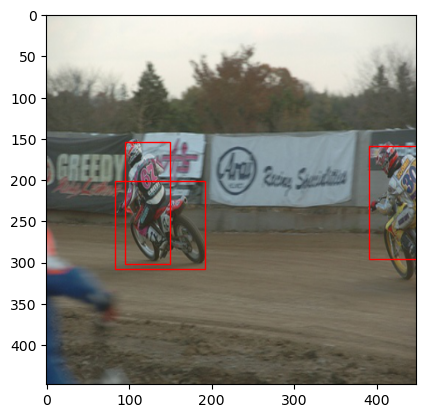

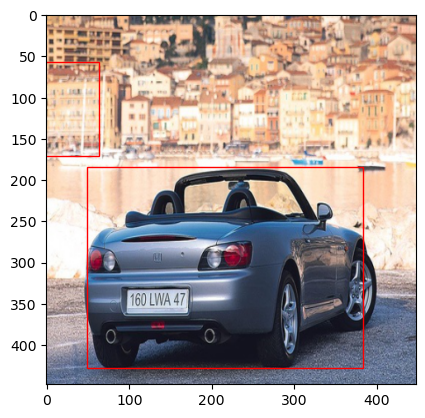

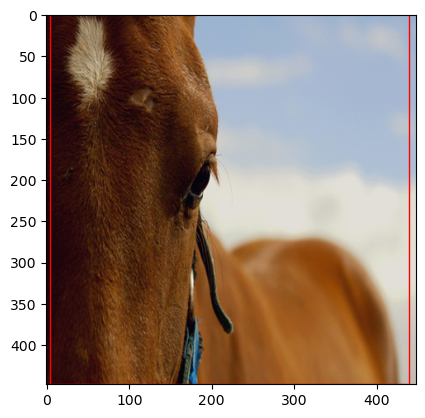

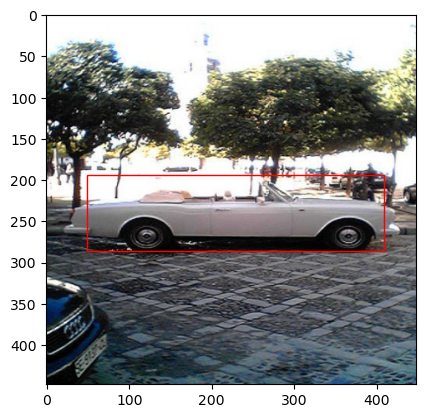

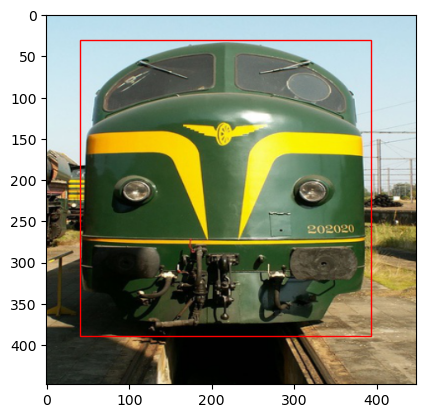

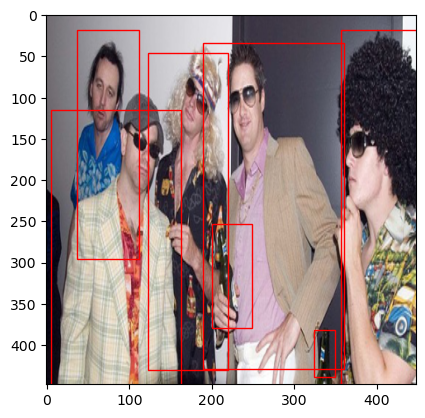

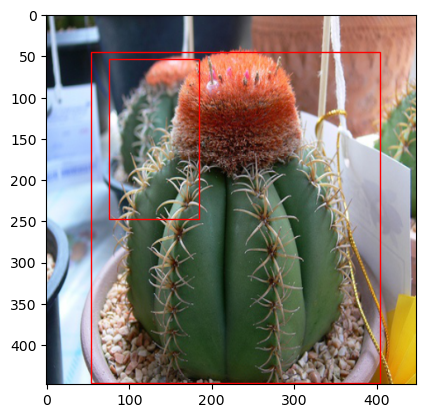

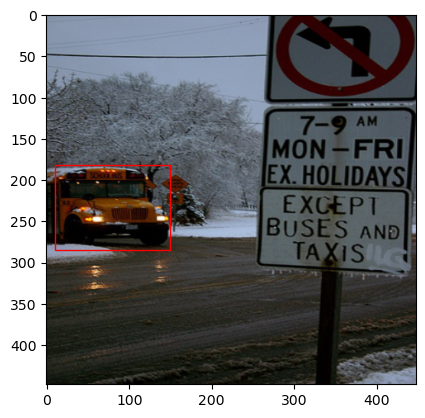

In [23]:
for x, y in train_loader:
    x = x.to(DEVICE)
    for idx in range(8):
        bboxes = cellboxes_to_boxes(model(x))
        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    break

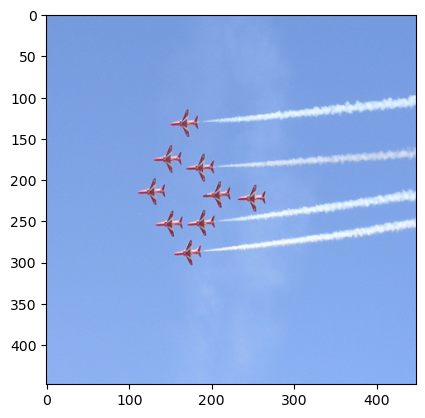

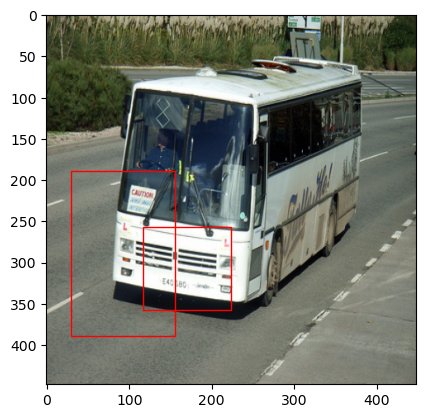

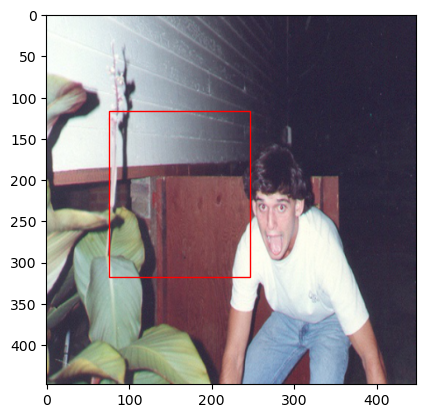

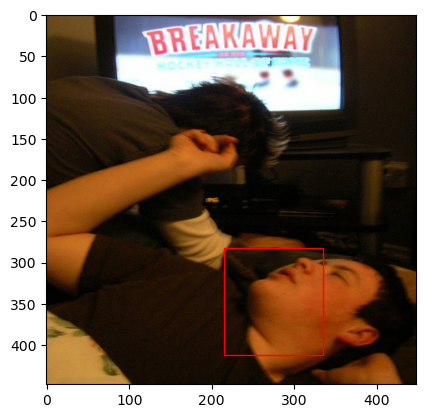

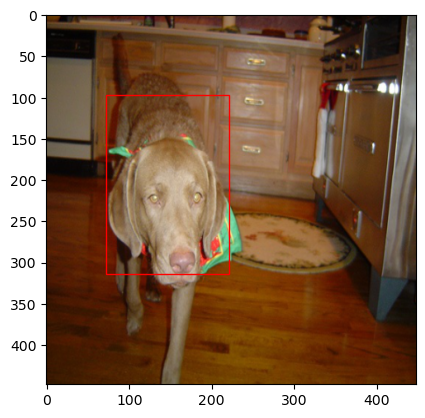

In [24]:
for x, y in test_loader:
    x = x.to(DEVICE)
    for idx in range(5):
        bboxes = cellboxes_to_boxes(model(x))
        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    break

In [25]:
pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4)

mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Test mAP: {mean_avg_prec}")

Test mAP: 0.0016522413352504373


In [26]:
pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)

mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
print(f"Train mAP: {mean_avg_prec}")

Train mAP: 0.9125405550003052
